# **PART** **A**

## **INSTALLING REQUIRED PACKAGES**

In [1]:
!pip install node2vec
!pip install networkx node2vec gensim
!pip install torch
!pip install torch-geometric

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 kB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 22.1 MB/s eta 0:00:00


## **Import required libraries**

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx
from node2vec import Node2Vec
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from torch_geometric.utils import from_networkx
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from torch_geometric.data import Data

## **LOADING THE DATASET USED IN ASSIGNMENT 1**

In [ ]:
!wget https://raw.githubusercontent.com/chinmay-rajpurohit/datasets/main/snads.csv
data_f = pd.read_csv('snads.csv')
data_f.head()

--2024-09-30 08:39:46--  https://raw.githubusercontent.com/chinmay-rajpurohit/datasets/main/snads.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 45217 (44K) [text/plain]
Saving to: ‘snads.csv’

snads.csv           100%[===================>]  44.16K  --.-KB/s    in 0.007s  

2024-09-30 08:39:47 (6.28 MB/s) - ‘snads.csv’ saved [45217/45217]



,Name,Country,Industry,Net Worth (in billions),Company
0,Rob Walton,Mexico,Finance,8.50,Walmart
1,Sergey Brin,USA,Automotive,44.76,Google
2,Steve Ballmer,USA,Manufacturing,13.43,Koch Industries
3,Mukesh Ambani,USA,Technology,120.44,Google
4,Jim Walton,USA,Fashion,122.39,Walmart


## **CREATING IT'S GRAPH**

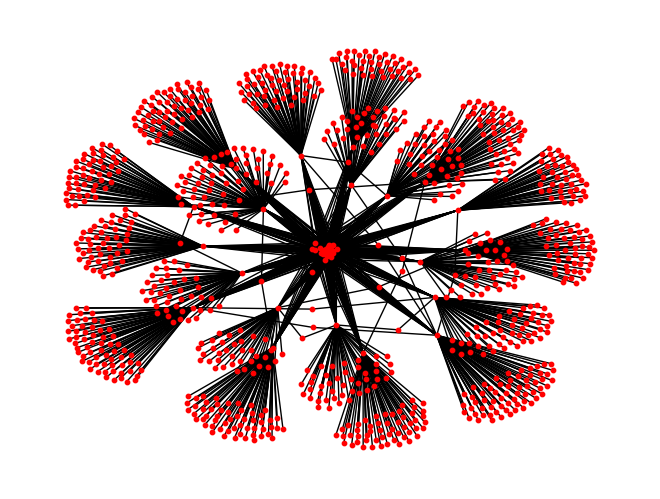

Graph with 1032 nodes and 1564 edges


In [ ]:
R_Graph = nx.Graph()
for i, row in data_f.iterrows():
    R_Graph.add_edge(row['Name'], row['Country'])
    R_Graph.add_edge(row['Name'], row['Industry'])
    R_Graph.add_edge(row['Name'], row['Company'])
    R_Graph.add_edge(row['Name'], row['Net Worth (in billions)'])

nx.draw(R_Graph, node_color='red', edge_color='black', node_size=10)
plt.show()
print(R_Graph)

## **Developing a shallow node embedding for the data using Node2Vec method used in class**

In [ ]:
node2vec = Node2Vec(R_Graph, dimensions=32, walk_length=50, num_walks=100, workers=4)
node2vec_model = node2vec.fit(window=10, min_count=1, batch_words=4)

node_embeddings = node2vec_model.wv
num_nodes = len(node_embeddings)
embedding_dim = node2vec_model.vector_size

print("node embedding for Rob Walton for example\n")
print(node_embeddings['Rob Walton'])

print(f"Number of nodes with embeddings: {num_nodes}")
print(f"Dimension of each embedding vector: {embedding_dim}")


Computing transition probabilities:   0%|          | 0/1032 [00:00<?, ?it/s]

node embedding for Rob Walton for example

[ 0.6004446   0.12751728 -0.23759861  0.1977128  -0.4428714  -0.01606848
  0.15328026 -0.3853114   0.02933669 -0.47600296  0.27845085 -0.490046
  0.22900337 -0.2736805   0.08914258 -0.2499947  -0.29623508  0.1004752
 -0.1868746   0.50602275  0.09238359  0.2746115   0.6141779  -0.6187959
 -0.09293646 -0.06332962  0.16991477  0.40251788  0.4512186   0.05392256
  0.56868607  0.24211386]
Number of nodes with embeddings: 1032
Dimension of each embedding vector: 32


## **MAKING EMBEDDING MATRIX and VISULAIZING THE EMBEDDINGS BY BOTH PCA and t-SNE**

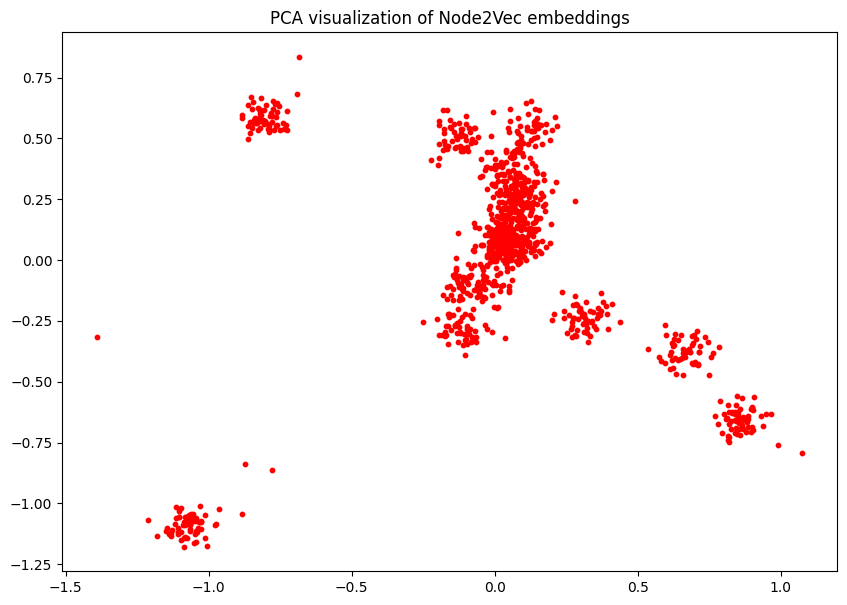

In [ ]:
embeddings_matrix = np.array([node_embeddings[node] for node in node_embeddings.index_to_key])

from sklearn.decomposition import PCA

pca = PCA(n_components=2)
embeddings_2d = pca.fit_transform(embeddings_matrix)

plt.figure(figsize=(10, 7))
plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], s=10, c='red')
plt.title("PCA visualization of Node2Vec embeddings")
plt.show()


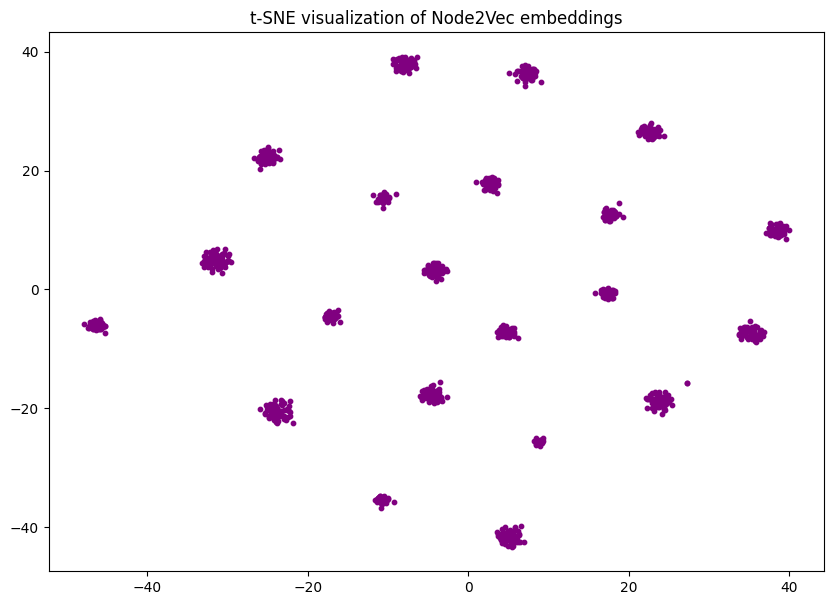

In [ ]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

tsne = TSNE(n_components=2, random_state=42)
embeddings_2d = tsne.fit_transform(embeddings_matrix)

plt.figure(figsize=(10, 7))
plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], s=10, c='purple')
plt.title("t-SNE visualization of Node2Vec embeddings")
plt.show()


## **DISPLAYING SOME MORE INFORMATION ABOUT EMBEDDINGS**

In [ ]:
similar_nodes = node2vec_model.wv.most_similar('Rob Walton')

print("Most similar nodes to node Rob Walton:")
for node, similarity in similar_nodes:
    print(f"Node {node}: Similarity {similarity}")
print('\n')

print("Embedding matrix shape:", embeddings_matrix.shape)

Most similar nodes to node Rob Walton:
Node 70.38: Similarity 0.9348470568656921
Node 94.94: Similarity 0.928058922290802
Node 95.47: Similarity 0.9278360605239868
Node 20.54: Similarity 0.9270647764205933
Node 6.94: Similarity 0.9259189963340759
Node 36.79: Similarity 0.9257857799530029
Node 154.84: Similarity 0.9243902564048767
Node 196.03: Similarity 0.9229835271835327
Node 113.23: Similarity 0.9228628873825073
Node 171.88: Similarity 0.9220173358917236


Embedding matrix shape: (1032, 32)


## **Convert embeddings to PyTorch tensor**

In [ ]:
data=from_networkx(R_Graph)
data.x = torch.tensor(embeddings_matrix, dtype=torch.float)

## **DEVELOPING A GNN MODEL**

In [ ]:
class GCN(torch.nn.Module):
    def __init__(self, in_channels,hidden_channels, out_channels):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, hidden_channels)
        self.conv3 = GCNConv(hidden_channels, out_channels)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index

        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.conv2(x, edge_index)
        x= F.relu(x)
        x = self.conv3(x, edge_index)

        return x


In [ ]:
model = GCN(in_channels=data.num_features, hidden_channels=16, out_channels=32)
print(model)

optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

GCN(
  (conv1): GCNConv(32, 16)
  (conv2): GCNConv(16, 16)
  (conv3): GCNConv(16, 32)
)


## **PUTTING MODEL UNDER TRAINING**

Epoch 0, Loss: 0.11619503796100616


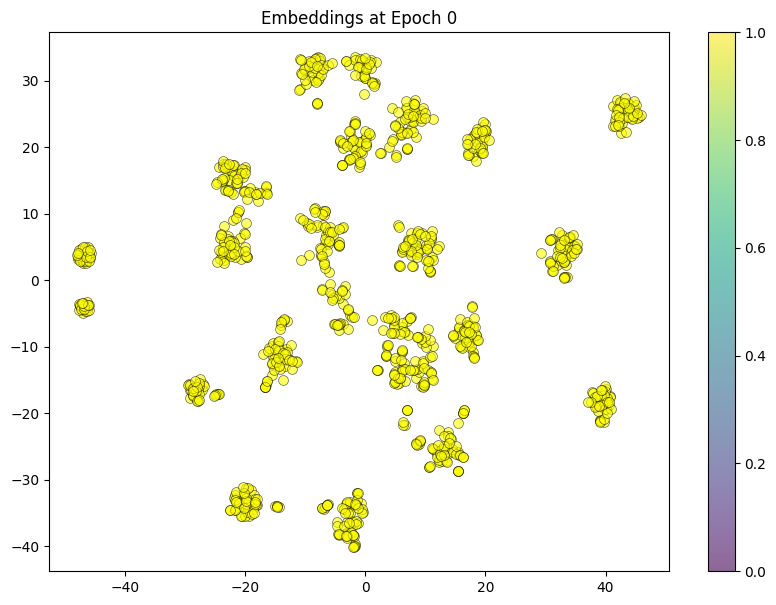

Epoch 0 embeddings: 
 [[ 0.20870027 -0.5920956  -0.30790856 ...  0.344978   -0.14057094
   0.41583443]
 [ 0.04387016 -0.25418356 -0.18641011 ...  0.09443165 -0.00951029
   0.17147303]
 [ 0.04150127 -0.24826887 -0.181107   ...  0.09096439 -0.00952546
   0.16617519]
 ...
 [ 0.03824916 -0.08558582 -0.05099724 ...  0.04008877 -0.00401671
   0.05450556]
 [ 0.0173221  -0.11293247 -0.09166436 ...  0.045762   -0.00062754
   0.08632708]
 [ 0.02408508 -0.08297665 -0.05704596 ...  0.03582415 -0.00785351
   0.05874964]]
Epoch 200, Loss: 0.021994199603796005


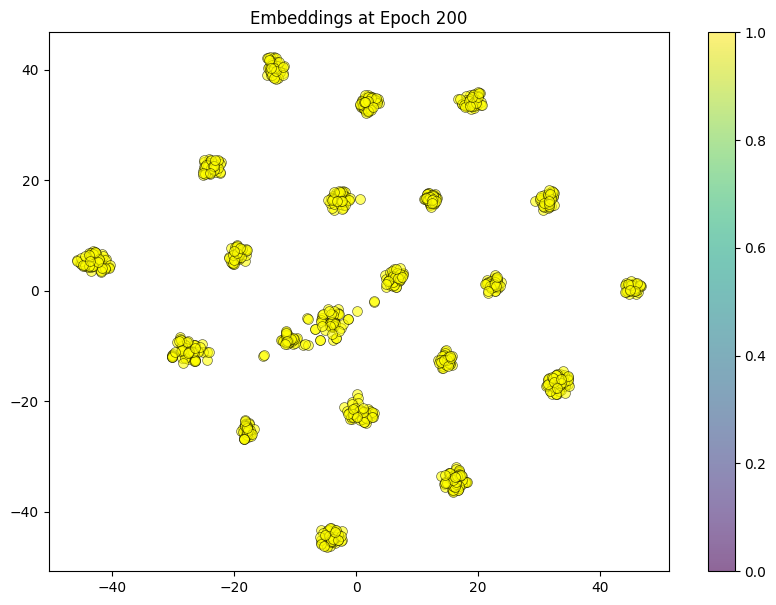

Epoch 200 embeddings: 
 [[-0.27705562 -0.09963713  0.21145615 ... -0.27733958 -0.5868579
   0.04102748]
 [ 0.08092074 -0.14976865  0.05479813 ... -0.14517428 -0.10468426
   0.0670126 ]
 [ 0.08147366 -0.15047455  0.05128721 ... -0.14324893 -0.10402209
   0.06613192]
 ...
 [ 0.36274678 -0.43768084 -0.11148454 ... -0.40557152 -0.04081808
   0.25164384]
 [-0.28554434  0.33830684 -0.28967926 ... -0.18504809 -0.31330544
   0.16707757]
 [ 0.3920836  -0.40555355 -0.16095963 ... -0.43843687 -0.07748015
   0.23000133]]
Epoch 400, Loss: 0.020955007523298264


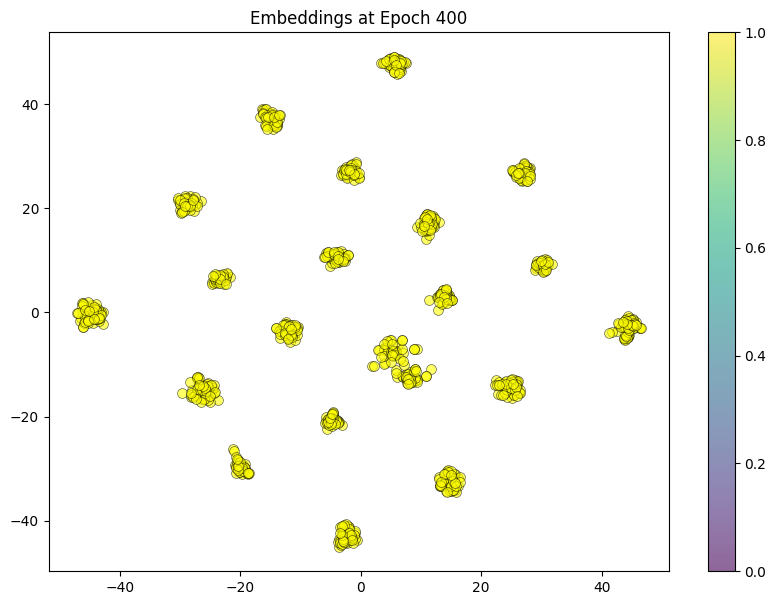

Epoch 400 embeddings: 
 [[-0.1508782  -0.06107848  0.2804311  ... -0.25189948 -0.65267175
  -0.02034381]
 [ 0.06887458 -0.14642979  0.06835198 ... -0.1464589  -0.09851983
   0.07211811]
 [ 0.06778351 -0.1472248   0.06199589 ... -0.1408523  -0.096815
   0.0705146 ]
 ...
 [ 0.3440905  -0.45892012 -0.14600196 ... -0.39191923 -0.09763046
   0.27950293]
 [-0.2628818   0.32063597 -0.3330021  ... -0.12840079 -0.28804803
   0.18054006]
 [ 0.37156945 -0.45723295 -0.18915531 ... -0.40170822 -0.0945408
   0.27997428]]


In [ ]:
model.train()
def plot_embeddings(epoch,embeddings, title):
    tsne = TSNE(n_components=2, random_state=0)
    embeddings_2d = tsne.fit_transform(embeddings)
    plt.figure(figsize=(10, 7))
    scatter = plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], s=50, alpha=0.6, edgecolors='black', linewidth=0.5, c='yellow')
    plt.colorbar(scatter)
    plt.title(title)
    plt.show()
    print(f"Epoch {epoch} embeddings: \n", embeddings)
for epoch in range(401):
    optimizer.zero_grad()
    out = model(data)
    loss = F.mse_loss(out, data.x)
    loss.backward()
    optimizer.step()
    if epoch in [0, 200, 400]:
        print(f'Epoch {epoch}, Loss: {loss.item()}')
        gcn_embeddings = out.cpu().detach().numpy()
        plot_embeddings(epoch,gcn_embeddings, f'Embeddings at Epoch {epoch}')

In [ ]:
model.eval()
gcn_embeddings = model(data).cpu().detach().numpy()

embeddings_2d_pca_gcn = pca.fit_transform(gcn_embeddings)
embeddings_2d_tsne_gcn = tsne.fit_transform(gcn_embeddings)
print(gcn_embeddings)

[[-0.15446103 -0.04939559  0.29526183 ... -0.25570744 -0.64563876
  -0.02215062]
 [ 0.0668666  -0.14550501  0.07021818 ... -0.14572628 -0.09797761
   0.0732715 ]
 [ 0.06564719 -0.14625555  0.06372334 ... -0.13992317 -0.09622701
   0.07164542]
 ...
 [ 0.3441897  -0.45647722 -0.14389256 ... -0.39154005 -0.0960381
   0.2788719 ]
 [-0.26338726  0.32140464 -0.33123475 ... -0.12803349 -0.28630123
   0.1813037 ]
 [ 0.37112805 -0.45534426 -0.1874528  ... -0.4011618  -0.09315054
   0.2799902 ]]


## **Display appropriate information about the model.**

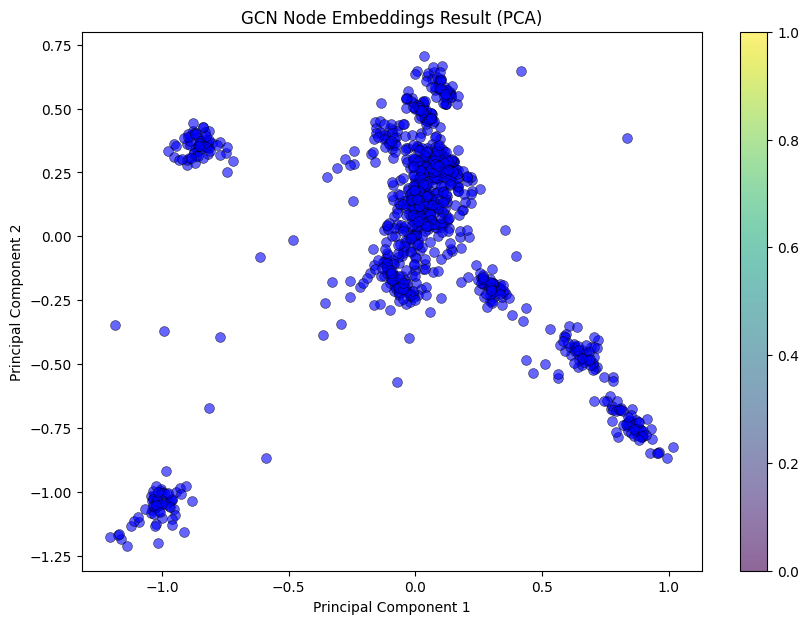

In [ ]:
plt.figure(figsize=(10, 7))
plt.scatter(embeddings_2d_pca_gcn[:, 0], embeddings_2d_pca_gcn[:, 1], s=50, alpha=0.6, edgecolors='black', c='blue', linewidths=0.5)
plt.title('GCN Node Embeddings Result (PCA)')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.colorbar()
plt.show()

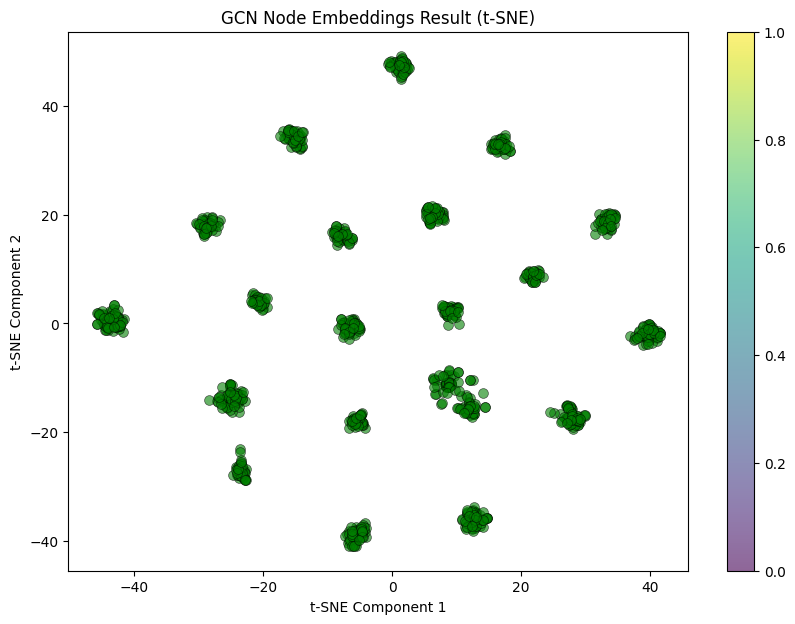

In [ ]:
plt.figure(figsize=(10, 7))
plt.scatter(embeddings_2d_tsne_gcn[:, 0], embeddings_2d_tsne_gcn[:, 1], s=50, alpha=0.6, edgecolors='black', c='green', linewidths=0.5)
plt.title('GCN Node Embeddings Result (t-SNE)')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.colorbar()
plt.show()

# **PART B**

### **IMPORTING LIBRARIES**

In [2]:
import os
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import networkx as nx
from torch_geometric.utils import to_networkx
import random

### **LOADING DATASET AND MAKING GRAPH**

In [3]:
edgelist = pd.read_csv("https://raw.githubusercontent.com/chinmay-rajpurohit/cora-citation/refs/heads/main/cora.cites", sep='\t', header=None, names=["target", "source"])
nodes = pd.read_csv("https://raw.githubusercontent.com/chinmay-rajpurohit/cora-citation/refs/heads/main/cora.content", sep='\t', header=None)
nodes.rename(columns={1434: "Label"}, inplace=True)


papers_map = dict()
labels_map = dict()
labels_index = 0

for i in range(len(nodes)):
    papers_map[nodes.iloc[i][0]] = i
    if nodes.iloc[i]['Label'] not in labels_map:
        labels_map[nodes.iloc[i]['Label']] = labels_index
        labels_index += 1

source, target = [], []
degree = [0] * len(nodes)

for i in range(len(edgelist)):
    source.append(papers_map[edgelist.iloc[i]['source']])
    target.append(papers_map[edgelist.iloc[i]['target']])
    degree[papers_map[edgelist.iloc[i]['source']]] += 1
    degree[papers_map[edgelist.iloc[i]['target']]] += 1

labels = [labels_map[nodes.iloc[i]['Label']] for i in range(len(nodes))]
nodes['Label'] = labels
nodes['Degree'] = degree

nodes.drop(columns=[0], inplace=True)
import torch_geometric
dataset = torch_geometric.data.data.Data()
dataset.num_classes = len(set(labels))
dataset.y = torch.tensor(nodes['Label'].to_numpy())
nodes.drop(columns=['Label'], inplace=True)
dataset.x = torch.tensor(nodes.to_numpy(), dtype=torch.float)
dataset.num_node_features = nodes.to_numpy().shape[1]
dataset.edge_index = torch.tensor([np.array(source), np.array(target)], dtype=torch.long)
dataset.num_nodes = nodes.shape[0]


perm = np.random.permutation(dataset.num_nodes)
train_split = int(0.15 * dataset.num_nodes)
dataset.train_mask = torch.tensor(perm > train_split)
dataset.test_mask = torch.tensor(perm <= train_split)


scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(dataset.x.numpy())
dataset.x = torch.tensor(scaled_data, dtype=torch.float)

<ipython-input-3-162153d0d745>:37: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  dataset.edge_index = torch.tensor([np.array(source), np.array(target)], dtype=torch.long)


### **VISUALIZING THE GRAPH**

Visualizing graph before training...


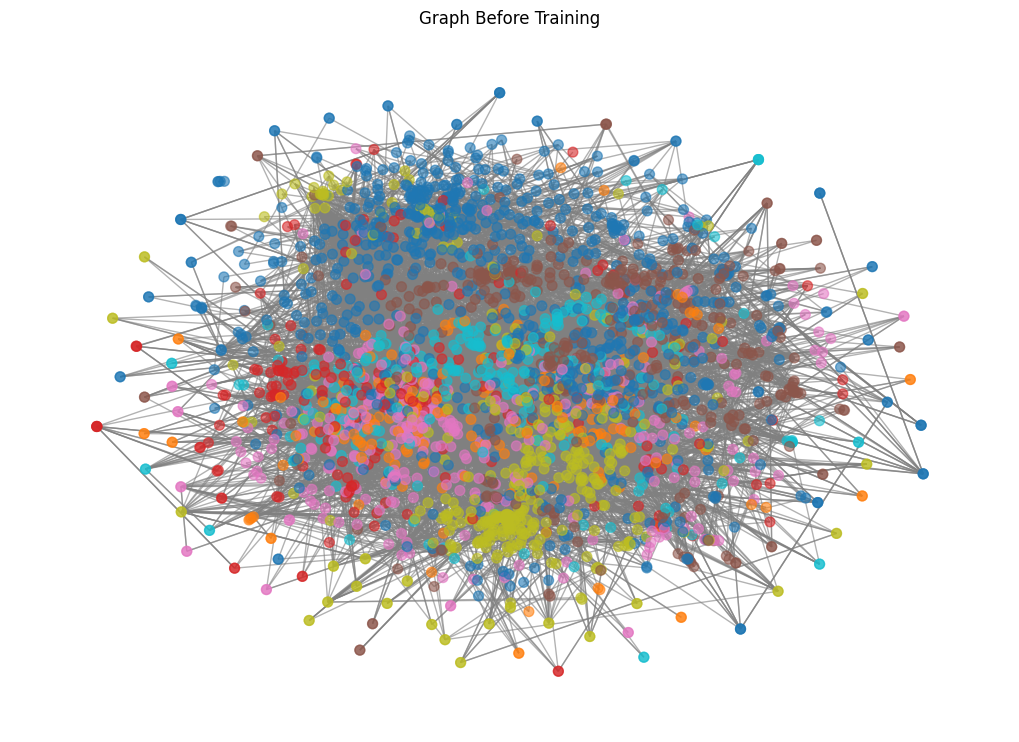

In [ ]:
def visualize_graph(embeddings, labels, edge_index, title):
    tsne = TSNE(n_components=2, random_state=42)
    embeddings_2d = tsne.fit_transform(embeddings)

    G = to_networkx(dataset, to_undirected=True)
    plt.figure(figsize=(10, 7))

    pos = {i: embeddings_2d[i] for i in range(len(embeddings_2d))}
    nx.draw(G, pos, node_color=labels, cmap='tab10', node_size=50, edge_color="gray", alpha=0.6)

    plt.title(title)
    plt.show()


print("Visualizing graph before training...")
visualize_graph(dataset.x.numpy(), dataset.y.numpy(), dataset.edge_index, "Graph Before Training")

In [ ]:
print(dataset.x)

tensor([[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0238],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0179],
        ...,
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0179],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0179],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0119]])


### **DEFINING GCN MODEL**

In [4]:
class GNNCora(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, n_layers, dropout=0.3):
        super(GNNCora, self).__init__()
        self.convs = nn.ModuleList([GCNConv(input_dim, hidden_dim)])
        for _ in range(n_layers - 1):
            self.convs.append(GCNConv(hidden_dim, hidden_dim))
        self.fc = nn.Linear(hidden_dim, output_dim)
        self.dropout = dropout

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        for conv in self.convs:
            x = conv(x, edge_index)
            x = F.relu(x)
            x = F.dropout(x, p=self.dropout, training=self.training)
        x = self.fc(x)
        return F.log_softmax(x, dim=1)

    def loss(self, pred, label):
        return F.nll_loss(pred, label)

### **BEST TEST ACCURACY ACHEIVED AND FINAL TEST ACCURACY**

In [5]:
def train(dataset, model, epochs=201, lr=0.005, weight_decay=5e-4):
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    best_accuracy = 0
    best_epoch = 0

    for epoch in range(epochs):
        model.train()
        optimizer.zero_grad()
        pred = model(dataset)
        loss = model.loss(pred[dataset.train_mask], dataset.y[dataset.train_mask])
        loss.backward()
        optimizer.step()

        train_acc = evaluate(dataset, model, dataset.train_mask)
        test_acc = evaluate(dataset, model, dataset.test_mask)

        if test_acc > best_accuracy:
            best_accuracy = test_acc
            best_epoch = epoch
            torch.save(model.state_dict(), 'best_model.pth')

        if epoch%20==0:
         print(f'Epoch: {epoch}, Loss: {loss:.4f}, Test Acc: {test_acc:.2f}%')
    print('\n')
    print(f"Best Test Accuracy: {best_accuracy:.2f}%")


def evaluate(dataset, model, mask):
    model.eval()
    with torch.no_grad():
        pred = model(dataset).argmax(dim=1)
        correct = pred[mask].eq(dataset.y[mask]).sum().item()
        total = mask.sum().item()
        return (correct / total) * 100


input_dim = dataset.num_node_features
hidden_dim = 128
output_dim = dataset.num_classes
n_layers = 1

model = GNNCora(input_dim, hidden_dim, output_dim, n_layers).to(torch.device('cpu'))
train(dataset, model)

Epoch: 0, Loss: 1.9440, Test Acc: 35.63%
Epoch: 20, Loss: 0.2762, Test Acc: 84.03%
Epoch: 40, Loss: 0.1029, Test Acc: 80.59%
Epoch: 60, Loss: 0.0776, Test Acc: 80.34%
Epoch: 80, Loss: 0.0675, Test Acc: 78.87%
Epoch: 100, Loss: 0.0564, Test Acc: 78.87%
Epoch: 120, Loss: 0.0495, Test Acc: 78.87%
Epoch: 140, Loss: 0.0447, Test Acc: 78.87%
Epoch: 160, Loss: 0.0392, Test Acc: 78.62%
Epoch: 180, Loss: 0.0355, Test Acc: 79.36%
Epoch: 200, Loss: 0.0355, Test Acc: 77.89%


Best Test Accuracy: 84.28%


### **VISUALIZING AFTER TRAINING**

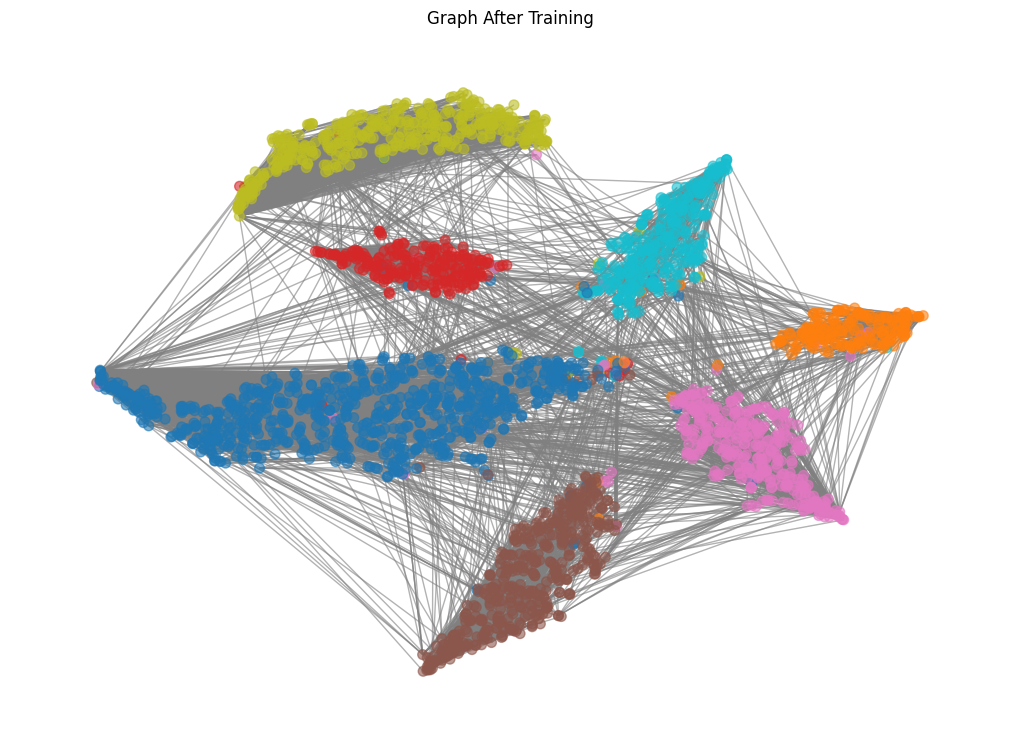

In [ ]:
with torch.no_grad():
    node_embeddings = model(dataset).detach().cpu().numpy()
    visualize_graph(node_embeddings, dataset.y.numpy(), dataset.edge_index, "Graph After Training")